In [21]:
# 使用するライブラリのimport
import os
import numpy as np

import torchvision.transforms as transforms
from torchvision.utils import save_image
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch
from torch.autograd import Variable, grad


In [24]:
# 定数の宣言
IMAGES_PATH = "images"                                  # 生成画像の出力先フォルダ
DATA_PATH = "data/mnist"                                # テストデータフォルダ

EPOCHS = 30                                             # エポック数
BATCH_SIZE = 64                                          # バッチサイズ

LEARNING_RATE = 0.0002                                 # 学習率
B1 = 0.5                                                   # 勾配のモメンタム １
B2 = 0.999                                                # 勾配のモメンタム 2

LATENT_DIM = 100                                        # 潜在変数（z)の次元数
IMG_SIZE = 28                                             # 画像の幅と高さ
CHANNELS = 1                                             # 画像のチャンネル数（１＝グレー）
img_shape = (CHANNELS, IMG_SIZE, IMG_SIZE)             # イメージ画像（チャンネル、幅、高さ）

N_CRITIC = 5                                              # Gの学習ステップ（D / iter）
CLIP_VALUE = 0.01                                        # 重みのクリップ範囲
SAMPLE_INTERVAL = 50                                   # 生成画像サンプリングのタイミング

LAMBDA_GP = 10                                          # 勾配ペナルティ

cuda = True if torch.backends.mps.is_available() else False          # GPUの利用チェック
print('GPU Check! gpu is ', cuda)


GPU Check! gpu is  True


In [7]:
# Generatorの定義
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(LATENT_DIM, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img


In [8]:
# Discriminatorの定義
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity

In [11]:
# GeneratorとDiscriminatorのインスタンス化
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.to("mps")
    discriminator.to("mps")

# MNISTデータの読み込み
os.makedirs(DATA_PATH, exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        DATA_PATH,
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(IMG_SIZE), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=BATCH_SIZE,
    shuffle=True,
)

# 生成画像の出力フォルダの作成
os.makedirs(IMAGES_PATH, exist_ok=True)

100%|██████████| 9912422/9912422 [00:01<00:00, 8544551.49it/s] 


Extracting data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to data/mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 23687073.49it/s]

Extracting data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to data/mnist/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 7941231.43it/s]


Extracting data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to data/mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 15822698.31it/s]

Extracting data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/mnist/MNIST/raw



In [12]:
# 最適化関数のセット
optimizer_G = torch.optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(B1, B2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(B1, B2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [13]:
"""# 勾配ペナルティ損失の計算
def compute_gradient_penalty(D, real_samples, fake_samples):
    # ランダムな混合割合を取得
    alpha = Tensor(np.random.random((real_samples.size(0), 1, 1, 1)))

    # 生成画像と実画像を一定の割合(alpha)で混ぜ合わせた画像でDの勾配を取得
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = Variable(Tensor(real_samples.shape[0], 1).fill_(1.0), requires_grad=False)
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]

    # 勾配ペナルティ損失を計算
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty
"""

In [22]:
def compute_gradient_penalty(D, real_samples, fake_samples):
    # MPSデバイスが利用可能かどうかを確認
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

    # ランダムな混合割合を取得
    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=device)

    # 生成画像と実画像を一定の割合(alpha)で混ぜ合わせた画像でDの勾配を取得
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)

    # grad_outputsは勾配計算に使用されるテンソルです
    fake = torch.ones(real_samples.shape[0], 1, device=device, requires_grad=False)

    # 勾配の計算
    gradients = grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]

    # 勾配ペナルティ損失の計算
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty


In [30]:
import torch
import numpy as np
from torch.autograd import Variable
from torchvision.utils import save_image

# MPSデバイスが利用可能かどうかを確認
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# モデルを適切なデバイスに移動
generator.to(device)
discriminator.to(device)

# 学習のログ用リスト
img_list = []
G_losses = []
D_losses = []

batches_done = 0

for epoch in range(EPOCHS):
    for i, (imgs, _) in enumerate(dataloader):
        imgs = imgs.to(device)

        # サンプルノイズの生成(正規分布に従ったランダムな値)
        z = Variable(torch.randn(imgs.shape[0], LATENT_DIM, device=device))

        # 判定ラベル
        valid = Variable(torch.ones(imgs.shape[0], 1, device=device), requires_grad=False)
        fake = Variable(torch.zeros(imgs.shape[0], 1, device=device), requires_grad=False)

        # リアル画像
        real_imgs = Variable(imgs.type(torch.float).to(device))

        # ---------------------
        #  Discriminatorの学習
        # ---------------------
        optimizer_D.zero_grad()

        # 本物の画像に対するDiscriminatorの応答
        real_validity = discriminator(real_imgs)

        # 生成された画像に対するDiscriminatorの応答
        fake_imgs = generator(z)
        fake_validity = discriminator(fake_imgs)

        # 勾配ペナルティ損失の計算
        gradient_penalty = compute_gradient_penalty(discriminator, real_imgs.data, fake_imgs.data)

        # 敵対的損失
        loss_D = -torch.mean(real_validity) + torch.mean(fake_validity) + LAMBDA_GP * gradient_penalty

        # 損失の逆伝播
        loss_D.backward()
        optimizer_D.step()

        # -----------------
        #  Generatorの学習
        # -----------------
        if i % N_CRITIC == 0:
            optimizer_G.zero_grad()

            # 生成された画像に対するDiscriminatorの応答
            gen_imgs = generator(z)
            loss_G = -torch.mean(discriminator(gen_imgs))

            loss_G.backward()
            optimizer_G.step()

            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, EPOCHS, batches_done % len(dataloader), len(dataloader), loss_D.item(), loss_G.item())
            )

        # ログ情報の収集
        G_losses.append(loss_G.item())
        D_losses.append(loss_D.item())
        

        # 一定の間隔で生成された画像を保存
        if batches_done % SAMPLE_INTERVAL == 0:
            save_image(fake_imgs.data[:25], IMAGES_PATH + "/%07d.png" % batches_done, nrow=5, normalize=True)
            # ログ情報の収集
            G_losses.append(loss_G.item())
            D_losses.append(loss_D.item())
            img_list.append(fake_imgs.data[:25])

        batches_done += 1



[Epoch 0/30] [Batch 0/938] [D loss: -1.955359] [G loss: -2.156609]
[Epoch 0/30] [Batch 5/938] [D loss: -1.513265] [G loss: -2.093333]
[Epoch 0/30] [Batch 10/938] [D loss: -1.737184] [G loss: -1.582460]
[Epoch 0/30] [Batch 15/938] [D loss: -1.753912] [G loss: -1.211979]
[Epoch 0/30] [Batch 20/938] [D loss: -1.788196] [G loss: -1.567202]
[Epoch 0/30] [Batch 25/938] [D loss: -1.822971] [G loss: -1.521609]
[Epoch 0/30] [Batch 30/938] [D loss: -1.580594] [G loss: -1.085456]
[Epoch 0/30] [Batch 35/938] [D loss: -1.708940] [G loss: -1.364798]
[Epoch 0/30] [Batch 40/938] [D loss: -1.281489] [G loss: -2.067428]
[Epoch 0/30] [Batch 45/938] [D loss: -1.453184] [G loss: -1.731626]
[Epoch 0/30] [Batch 50/938] [D loss: -1.840172] [G loss: -1.937734]
[Epoch 0/30] [Batch 55/938] [D loss: -1.313557] [G loss: -2.344397]
[Epoch 0/30] [Batch 60/938] [D loss: -1.594544] [G loss: -2.620171]
[Epoch 0/30] [Batch 65/938] [D loss: -1.294376] [G loss: -1.693038]
[Epoch 0/30] [Batch 70/938] [D loss: -1.584738] [G

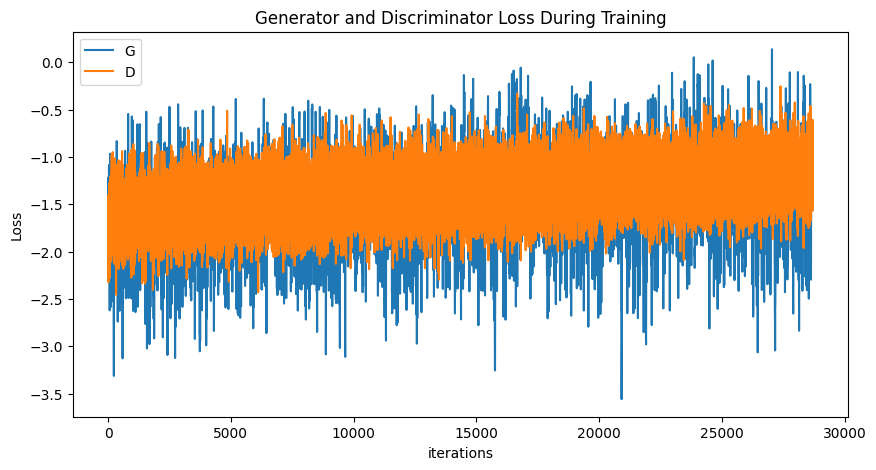

In [31]:
# 学習結果の可視化
import torchvision.utils as vutils
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# 生成した画像をアニメーションGIFとして保存する
imgs = []
    
# 保存しているtorch.TensorをPil Imageに変換する
i = 0
for img in img_list :
  if(i%10) == 0:
      img_temp = vutils.make_grid(img, padding=2, nrow=5, normalize=True)
      imgs.append(transforms.functional.to_pil_image(img_temp))
  i += 1
    
imgs[0].save(
    "./Generator.gif", save_all=True, append_images=imgs[1:], duration=500, loop=0
)

In [36]:
img_list[0][0][0].to_image()

AttributeError: 'Tensor' object has no attribute 'to_image'

In [43]:
from PIL import Image


tensor = img_list[-1][0][0]
# テンソルの値を0から1に正規化
tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min())

# テンソルを0から255のスケールに変換
tensor = tensor * 255

# テンソルをNumPy配列に変換し、整数型にキャスト
array = tensor.cpu().numpy()

# NumPy配列をPillowのImageオブジェクトに変換
img = Image.fromarray(array, 'L')  # 'L'はグレースケールを意味します
img.show()